# Predicting the Prevalence of Poor Mental Health in the U.S.
---
The below script explores the relationship between the prevalence of poor mental health and the prevalence of certain unhealthy behaviors in the United States. We also look at various socioeconomic parameters to see if they can further inform our findings.

In this script, we retrieved and analyzed data from the 500 Cities: 2016 Census Tract-level Data, as well as 2016 socioeconomic data from the American Community Survey and geographical data. We used Pandas, Numpy, Matplotlib, Seaborn, Requests, and Google API to accomplish our task.

# Importing the dependencies

In this section we import the modules and API key we will need for our analysis.

In [82]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import gmaps
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Configure gmaps
from config import gkey
gmaps.configure(api_key=gkey)

# configure plotly
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='maaikerutten', api_key='ACCa5zkpWP6lC4yBHPMg')


# Defining functions we'll be calling throughout the notebook
#### Seaborn Correlations Heatmap
A quick way to explore correlations among our variables is to build a correlations heatmap using seaborn. We create our own color gradient map, with high correlations displayed in increasing red shades, and lower correlations trending into the blue hues. We also add our correlation values inside the graph itself, displaying floating numbers in each category (source: https://ajh1143.github.io/Corr/)

#### Plotly Choropleth map
A choropleth map can show is where to find higher and lower concentrations of certain values. A high percentage of poor mental health is displayed in increasing purple shades and lower in light purple. 

#### Anova & Tukey's Range tests
After we divide our data into 4 bins corresponding to the quartiles on the prevalence of poor mental health, we repeptitively draw boxplots and test for any significant difference among the four groups along a number of health and socioeconomic variables.

In [83]:
# Defining a function for creating correlations heatmap (we will use this code again on the ACS16 dataset,
# as well as the final merged dataset)
def correlations_heatmap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()
    


# Defining a function for displaying boxplots by MH bins, and performing ANOVA and Tukey's Range tests
# (this code will be used repetitively throughout our data exploration section)
def anova_analysis(df, var):
    plt.figure(figsize=(20, 10))
    sns.set_style("whitegrid")
    sns.set_palette("Blues")
    # Displaying the boxplots
    df_sorted = df.sort_values('quantile')
    x = sns.boxplot(data=df_sorted, x='quantile', y=var, saturation=1, width=0.8)
    plt.title(f"Studying {var}")
    plt.show()
    # Performing ANOVA test
    group1 = df[df["quantile"] == 'low'][var]
    group2 = df[df["quantile"] == 'low-med'][var]
    group3 = df[df["quantile"] == 'med-high'][var]
    group4 = df[df["quantile"] == 'high'][var]
    anova_results = stats.f_oneway(group1, group2, group3, group4)
    print(anova_results)
    # Performing Tukey's Range test
    tukey_results = pairwise_tukeyhsd(df_sorted[var], df_sorted['quantile'], 0.05)
    print(tukey_results)
    
# Defining a function to run a multiple linear regression analysis model to help
# predict the prevalence of poor mental health
def mult_reg(x):
    # Create DataFrame y to hold our dependent variable
    y = df[['HO_poor_mental_health']]
    # Split x into 80% training set and 20% testing set
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    # Build the linear regression model & fit the model using x_train and y_train
    mlr = LinearRegression()
    model = mlr.fit(x_train, y_train)
    # Use the model to predict y-values from x_test
    y_predict = mlr.predict(x_test)
    # Visualize the fitplt.scatter(y_test, y_predict, alpha=0.7)
    plt.scatter(y_test, y_predict, c='b', alpha=1)
    plt.xlabel("Prevalence of poor MH")
    plt.ylabel("Predicted prevalence of poor MH")
    plt.title("Actual Prevalence of Poor MH vs Predicted Prevalence of Poor MH")
    plt.show()
    # Looking at the regression intercept and coefficients
    print('Intercept: \n', mlr.intercept_)
    print('Coefficients: \n', mlr.coef_)
    # Evaluate accuracy of our model (R-square)
    print(f"Train score: {mlr.score(x_train, y_train)}")
    print(f"Test score: {mlr.score(x_test, y_test)}")
    # with statsmodels
    x = sm.add_constant(x) # adding a constant
    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 
    print_model = model.summary()
    print(print_model)


# Loading the data

- "500_Census_Tracts.csv" (source: https://dev.socrata.com/foundry/chronicdata.cdc.gov/47z2-4wuh). This dataset contains 2016 model-based estimates of 27 health indicators collected from adults ages 18 to 64 in 27210 census tracts. The 27 health indicators include 13 health outcomes (among which we selected to study the prevalence of poor mental health), 5 unhealthy behaviors (which we all include in our study), and 10 preventive services (four of which we selected to include in our study)
- "ACS_2016.csv" (source: https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml, select advanced search). This dataset was custom-built following a search by date, geographical and socioeconomic variables from the American FactFinder advanced search tool.

In [84]:
# Loading the 500 Cities: Census Tract-level data
tracts_df = pd.read_csv('500_Census_Tracts.csv')

# Selecting, renaming, and reordering the columns we want for our analysis
tracts_reduced = tracts_df[['StateAbbr', 'PlaceName', 'MHLTH_CrudePrev', 'SLEEP_CrudePrev', 'LPA_CrudePrev',
                            'OBESITY_CrudePrev', 'CSMOKING_CrudePrev', 'BINGE_CrudePrev', 'ACCESS2_CrudePrev',
                            'CHECKUP_CrudePrev', 'COREM_CrudePrev', 'COREW_CrudePrev', 'PlaceFIPS', 'TractFIPS',
                            'Place_TractID', 'Geolocation']]
tracts_reduced.rename(columns = {
    'StateAbbr': 'state', #State abbreviation
#    'PlaceName': 'city',
    'PlaceFIPS': 'city_FIPS', #City FIPS code
    'TractFIPS': 'tract_FIPS', #Tract FIPS code
#    'Place_TractID': 'place_tractID',
    'ACCESS2_CrudePrev': 'PS_lack_health_ins', #Model-based estimate for crude prevalence of current lack of health insurance among adults aged 18-64 years, 2016
    'CHECKUP_CrudePrev': 'PS_routine_checkups', #Model-based estimate for crude prevalence of visits to doctor for routine checkup within the past year among adults aged >=18 years, 2016
    'COREM_CrudePrev': 'PS_older_men_uptodate', #Model-based estimate for crude prevalence of older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, 2016
    'COREW_CrudePrev': 'PS_older_women_uptodate', #Model-based estimate for crude prevalence of older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years, 2016
    'BINGE_CrudePrev': 'UB_binge_drinking', #Model-based estimate for crude prevalence of binge drinking among adults aged >=18 years, 2016
    'CSMOKING_CrudePrev': 'UB_current_smoking', #Model-based estimate for crude prevalence of current smoking among adults aged >=18 years, 2016
    'LPA_CrudePrev': 'UB_lack_physical_activity', #Model-based estimate for crude prevalence of no leisure-time physical activity among adults aged >=18 years, 2016
    'OBESITY_CrudePrev': 'UB_obesity', #Model-based estimate for crude prevalence of obesity among adults aged >=18 years, 2016
    'SLEEP_CrudePrev': 'UB_less_sleep', #Model-based estimate for crude prevalence of sleeping less than 7 hours among adults aged >=18 years, 2016
    'MHLTH_CrudePrev': 'HO_poor_mental_health', #Model-based estimate for crude prevalence of mental health not good for >=14 days among adults aged >=18 years, 2016
    'Geolocation': 'geolocation'}, inplace = True) #Latitude, longitude of census tract centroid


In [85]:
# Loading the 2016 ACS select data
acs16_df = pd.read_csv('ACS_2016.csv')

# Selecting, renaming, and reordering the columns we want for our analysis
acs16_reduced = acs16_df[['HC01_EST_VC01', 'HC03_EST_VC01', 'HC03_EST_VC07', 'HC01_EST_VC08',
                          'HC01_EST_VC09', 'HC01_EST_VC10', 'HC01_EST_VC11', 'HC01_EST_VC12', 'HC01_EST_VC13',
                          'HC01_EST_VC20', 'HC01_EST_VC21', 'HC01_EST_VC54', 'HC01_EST_VC55',
                          'HC01_EST_VC56', 'HC01_EST_VC57', 'HC01_EST_VC58', 'HC01_EST_VC74', 'HC01_EST_VC75',
                          'HC01_EST_VC76', 'HC01_EST_VC77', 'HC01_EST_VC78', 'HC01_EST_VC79'
                         ]].apply(pd.to_numeric, errors='coerce')
acs16_reduced['geo_id'] = acs16_df['GEO.id2']
acs16_reduced.rename(columns = {
    'HC01_EST_VC01': 'population_CNI',
    'HC03_EST_VC01': 'population_%insured',
    'HC03_EST_VC07': 'age18to64_%insured',
    'HC01_EST_VC08': 'age18to24',
    'HC01_EST_VC09': 'age25to34',
    'HC01_EST_VC10': 'age35to44',
    'HC01_EST_VC11': 'age45to54',
    'HC01_EST_VC12': 'age55to64',
    'HC01_EST_VC13': 'age_over64',
    'HC01_EST_VC20': 'male',
    'HC01_EST_VC21': 'female',
    'HC01_EST_VC54': 'education_over25',
    'HC01_EST_VC55': 'over25_lessThanHS',
    'HC01_EST_VC56': 'over25_HS',
    'HC01_EST_VC57': 'over25_someCollege',
    'HC01_EST_VC58': 'over25_college',
    'HC01_EST_VC74': 'household_income',
    'HC01_EST_VC75': 'household_income_under$25K',
    'HC01_EST_VC76': 'household_income_$25to49K',
    'HC01_EST_VC77': 'household_income_$50to74K',
    'HC01_EST_VC78': 'household_income_$75to99K',
    'HC01_EST_VC79': 'household_income_over$99K'
}, inplace = True)

# Adding columns for percent of various socioeconomic factors
acs16_reduced['age_over18'] = acs16_reduced.age18to24 + acs16_reduced.age25to34 + acs16_reduced.age35to44 + acs16_reduced.age45to54 + acs16_reduced.age55to64 + acs16_reduced.age_over64
acs16_reduced['percent_age18to24'] = acs16_reduced.age18to24 / acs16_reduced.age_over18
acs16_reduced['percent_age25to34'] = acs16_reduced.age25to34 / acs16_reduced.age_over18
acs16_reduced['percent_age35to44'] = acs16_reduced.age35to44 / acs16_reduced.age_over18
acs16_reduced['percent_age45to54'] = acs16_reduced.age45to54 / acs16_reduced.age_over18
acs16_reduced['percent_age55to64'] = acs16_reduced.age55to64 / acs16_reduced.age_over18
acs16_reduced['percent_age_over64'] = acs16_reduced.age_over64 / acs16_reduced.age_over18
acs16_reduced['percent_male'] = acs16_reduced.male / acs16_reduced.population_CNI
acs16_reduced['percent_female'] = acs16_reduced.female / acs16_reduced.population_CNI
acs16_reduced['percent_lessThanHS'] = acs16_reduced.over25_lessThanHS / acs16_reduced.education_over25
acs16_reduced['percent_HS'] = acs16_reduced.over25_HS / acs16_reduced.education_over25
acs16_reduced['percent_someCollege'] = acs16_reduced.over25_someCollege / acs16_reduced.education_over25
acs16_reduced['percent_college'] = acs16_reduced.over25_college / acs16_reduced.education_over25
acs16_reduced['percent_hIncome_under$25K'] = acs16_reduced['household_income_under$25K'] / acs16_reduced.household_income
acs16_reduced['percent_hIncome_$25to49K'] = acs16_reduced['household_income_$25to49K'] / acs16_reduced.household_income
acs16_reduced['percent_hIncome_$50to74K'] = acs16_reduced['household_income_$50to74K'] / acs16_reduced.household_income
acs16_reduced['percent_hIncome_$75to99K'] = acs16_reduced['household_income_$75to99K'] / acs16_reduced.household_income
acs16_reduced['percent_hIncome_over$99K'] = acs16_reduced['household_income_over$99K'] / acs16_reduced.household_income

# Checking for NaN values
acs16_final = acs16_reduced[['percent_age18to24', 'percent_age25to34', 'percent_age35to44', 'percent_age45to54',
                             'percent_age55to64', 'percent_age_over64', 'percent_male', 'percent_female',
                             'percent_lessThanHS', 'percent_HS', 'percent_someCollege',
                             'percent_college', 'percent_hIncome_under$25K', 'percent_hIncome_$25to49K',
                             'percent_hIncome_$50to74K', 'percent_hIncome_$75to99K', 'percent_hIncome_over$99K',
                             'geo_id']]

# Preparing a choropleth via plotly to display the prevalence of poor mental health across the U.S.
in this section we display a choropleth for the prevalence of poor mental health based on the 27210 censsu tracts of our dataset shown per U.S. State

In [86]:
# Defining a function for creating a choropleth 
for col in tracts_reduced.columns:
    tracts_reduced[col] = tracts_reduced[col].astype(str)
# generate colormap   
    colorscale = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

    tracts_reduced['text'] = tracts_reduced['state']            
# data                           
    dataChoropleth = [ dict(
        type='choropleth',
        colorscale = colorscale,
        autocolorscale = False,
        locations = tracts_reduced['state'],
        z = tracts_reduced['HO_poor_mental_health'].astype(float),
        locationmode = 'USA-states',
        text = tracts_reduced['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Percent of residents with poor mental health")
        ) ]

    layout = dict(
        title = 'Poor Mental Heath by state',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )

figureChoropleth = dict( data=dataChoropleth, layout=layout )
py.iplot( figureChoropleth, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~maaikerutten/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


# Preparing a heat map to display the prevalence of poor mental health across the U.S.

In this section we display a heat map for the prevalence of poor mental health based on the 27210 census tracts of our dataset.

In [87]:
# Extracting census tracts latitude and longitude from 'geolocation' text field in tracts_df
# and transforming type from string to float
tracts_reduced['lat'] = tracts_reduced.geolocation.apply(lambda x: x[1:15]).astype(float)
tracts_reduced['lng'] = tracts_reduced.geolocation.apply(lambda x: x[17:31]).astype(float)
locations = tracts_reduced[['lat', 'lng']]
MH_score = tracts_reduced['HO_poor_mental_health']

# Plot heatmap for prevalence of poor mental health by census tracts
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=MH_score,
                                 dissipating=False, max_intensity=1000,
                                 point_radius=1)
fig.add_layer(heat_layer)
fig  # Display figure

Figure(layout=FigureLayout(height='420px'))

# Cleaning up the census tracts dataset

In this section, we clean up and prepare our main dataset for analysis. Specifically:
- we plot the correlation matrix among our variables of interest and remove the one(s) with little or no correlation with our dependent variable ('HO_poor_mental_health'). We notice that 'PS_routine_checkups' has no correlation with 'HO_poor_mental_health', so we remove it from further analysis.
- our census tracts data frame (based on the "500_Census_Tracts.csv" file) has a few NaN values we want to remove;
- we notice that the distribution of the prevalence of poor mental is normal-ish, but slightly skewed to the right
- we identify and remove outliers from the dataset (source: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

ValueError: zero-size array to reduction operation minimum which has no identity

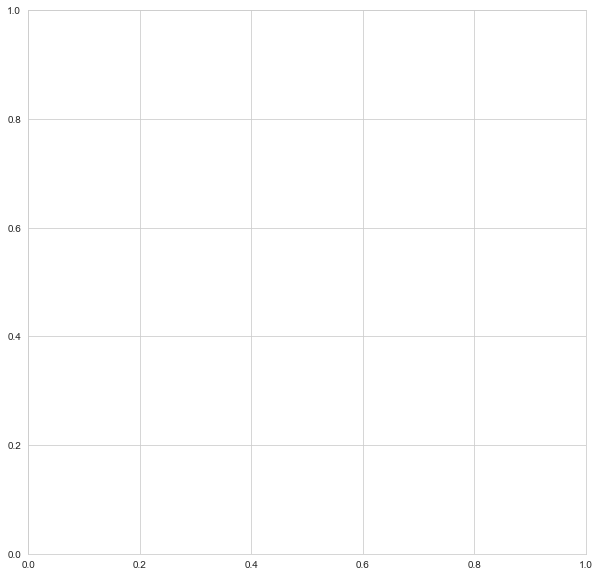

In [88]:
# Checking out correlations in our census tracts dataset
tracts_var = tracts_reduced[['HO_poor_mental_health', 'UB_less_sleep', 'UB_lack_physical_activity', 'UB_obesity',
                             'UB_current_smoking', 'UB_binge_drinking', 'PS_lack_health_ins', 'PS_routine_checkups',
                             'PS_older_men_uptodate', 'PS_older_women_uptodate']]
correlations_heatmap(tracts_var)

In [89]:
# Dropping the 'PS_routine_checkups' from the dataset
tracts_reduced.drop(['PS_routine_checkups'], axis=1)

# Checking for NaN values in tracts_reduced dataframe
print('BEFORE REMOVING NaN VALUES:')
print('---------------------------')
print(tracts_reduced.count())

# Dropping NaN values in tracts_reduced dataframe
tracts_clean = tracts_reduced.dropna()
print('AFTER REMOVING NaN VALUES:')
print('--------------------------')
print(tracts_clean.count())

BEFORE REMOVING NaN VALUES:
---------------------------
state                        27210
PlaceName                    27210
HO_poor_mental_health        27210
UB_less_sleep                27210
UB_lack_physical_activity    27210
UB_obesity                   27210
UB_current_smoking           27210
UB_binge_drinking            27210
PS_lack_health_ins           27210
PS_routine_checkups          27210
PS_older_men_uptodate        27210
PS_older_women_uptodate      27210
city_FIPS                    27210
tract_FIPS                   27210
Place_TractID                27210
geolocation                  27210
text                         27210
lat                          27210
lng                          27210
dtype: int64
AFTER REMOVING NaN VALUES:
--------------------------
state                        27210
PlaceName                    27210
HO_poor_mental_health        27210
UB_less_sleep                27210
UB_lack_physical_activity    27210
UB_obesity                   27210
UB

# Aggregating by cities
In this section we aggregate our health indicators/census tracts clean dataset by cities and merge it with the 2016 ACS dataset.

In [90]:
tracts_clean.columns

Index(['state', 'PlaceName', 'HO_poor_mental_health', 'UB_less_sleep',
       'UB_lack_physical_activity', 'UB_obesity', 'UB_current_smoking',
       'UB_binge_drinking', 'PS_lack_health_ins', 'PS_routine_checkups',
       'PS_older_men_uptodate', 'PS_older_women_uptodate', 'city_FIPS',
       'tract_FIPS', 'Place_TractID', 'geolocation', 'text', 'lat', 'lng'],
      dtype='object')

In [91]:
# Extracting and formatting the geographical code for cities from 'city_FIPS'
# (we will need it later to merge both datasets)
tracts_clean['geo_id'] = tracts_clean.city_FIPS.apply(
    lambda x: '0' + str(x) if len(str(x)) == 6 else str(x))

# Grouping by cities
tracts_groups = tracts_clean.groupby(['geo_id'])

# Calculating means for health indicators (HI) grouped by cities
HI_means = tracts_groups['HO_poor_mental_health', 'UB_binge_drinking', 'UB_current_smoking',
                         'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                         'PS_older_men_uptodate', 'PS_older_women_uptodate', 'lat', 'lng'].mean().reset_index()
# Add city names
cities = tracts_groups['state', 'PlaceName'].max()
HI_final = pd.merge(HI_means, cities, on='geo_id')

# Create master df
df = pd.merge(HI_final, acs16_final, on='geo_id')
print(f"There are {len(df)} cities represented in our final dataset, after merging with the ACS_2016 dataset.")

There are 495 cities represented in our final dataset, after merging with the ACS_2016 dataset.


## Binning by mental health (MH) scores

In [92]:
#plt.hist(df['HO_poor_mental_health'], bins=20)
df['HO_poor_mental_health'].describe()

KeyError: 'HO_poor_mental_health'

In [93]:
# Calculate quantiles on mental health outcome (MH) & prepare bins
bins = [5]
MH_Q1 = df['HO_poor_mental_health'].quantile(0.25)
bins.append(MH_Q1)
MH_Q2 = df['HO_poor_mental_health'].quantile(0.5)
bins.append(MH_Q2)
MH_Q3 = df['HO_poor_mental_health'].quantile(0.75)
bins.append(MH_Q3)
bins.append(20)
print(bins)
labels = ['low', 'low-med', 'med-high', 'high']
print(labels)

# Append our bins to df
df['quantile'] = pd.cut(df['HO_poor_mental_health'], bins, labels=labels)
df['quantile'].value_counts()

KeyError: 'HO_poor_mental_health'

# Exploring differences in various health indicators by mental health (MH) bins
In this section we first look at the correlation heatmap and boxplots displaying various health indicators by quartile of mental health outcome. Using ANOVA and Tukey's Range tests, we verify whether the differences observed are statistically significant.
Then we look at the correlation heatmap and build a multiple linear regression predicting the prevalence of poor mental health based on statistically significant health indicators.

### CORRELATIONS HEATMAP

In [94]:
# Checking out correlations within our master dataset
df_var = df[['HO_poor_mental_health', 'UB_less_sleep', 'UB_lack_physical_activity', 'UB_obesity',
             'UB_current_smoking', 'UB_binge_drinking', 'PS_lack_health_ins','PS_older_men_uptodate',
             'PS_older_women_uptodate']]
correlations_heatmap(df_var)

KeyError: "['HO_poor_mental_health' 'UB_less_sleep' 'UB_lack_physical_activity'\n 'UB_obesity' 'UB_current_smoking' 'UB_binge_drinking'\n 'PS_lack_health_ins' 'PS_older_men_uptodate' 'PS_older_women_uptodate'] not in index"

### BOXPLOTS

In [79]:
anova_analysis(df, 'UB_binge_drinking')

KeyError: 'quantile'

<Figure size 1440x720 with 0 Axes>

In [80]:
anova_analysis(df, 'UB_current_smoking')

KeyError: 'quantile'

<Figure size 1440x720 with 0 Axes>

In [81]:
anova_analysis(df, 'UB_lack_physical_activity')

KeyError: 'quantile'

<Figure size 1440x720 with 0 Axes>

In [ ]:
anova_analysis(df, 'UB_obesity')

In [ ]:
anova_analysis(df, 'UB_less_sleep')

In [ ]:
anova_analysis(df, 'PS_lack_health_ins')

In [ ]:
anova_analysis(df, 'PS_older_men_uptodate')

In [ ]:
anova_analysis(df, 'PS_older_women_uptodate')

### MULTIPLE REGRESSION ANALYSIS MODEL

In [ ]:
# Create DataFrame x to hold our independent variables (all of our health indicators)
ind_var1 = df[['UB_less_sleep', 'UB_lack_physical_activity', 'UB_obesity',
             'UB_current_smoking', 'UB_binge_drinking', 'PS_lack_health_ins','PS_older_men_uptodate',
             'PS_older_women_uptodate']]
mult_reg(ind_var1)

In [ ]:
# Create DataFrame x to hold our independent variables (all of our health indicators, minus obesity)
ind_var2 = df[['UB_less_sleep', 'UB_lack_physical_activity', 'UB_current_smoking', 'UB_binge_drinking',
               'PS_lack_health_ins','PS_older_men_uptodate', 'PS_older_women_uptodate']]
mult_reg(ind_var2)

# Exploring differences in socioeconomic characteristics by mental health (MH) bins
In this section we first look at stacked bar charts displaying various socioeconomic variables by quartile of mental health outcome. We further highlight striking differences with scatter and box plots and test for statistical significance using ANOVA and Tukey's Range tests.
Then we build a multiple linear regression predicting the prevalence of poor mental health based on statistically significant socioeconomic variables.

### STACKED BAR CHARS, SCATTER PLOTS & BOXPLOTS

In [ ]:
# Looking at age distribution across MH quantiles
sns.set_style("whitegrid")
sns.set_palette("cubehelix", 6)
MH_groups = df.groupby(['quantile'])
MH_age = MH_groups['percent_age18to24', 'percent_age25to34', 'percent_age35to44',
                   'percent_age45to54', 'percent_age55to64', 'percent_age_over64'].mean().reset_index()
MH_age.plot.bar(stacked=True, figsize=(20, 10))
plt.show()

In [ ]:
# Looking at household income distribution across MH quantiles
sns.set_style("whitegrid")
sns.set_palette("cubehelix", 5)
MH_groups = df.groupby(['quantile'])
MH_income = MH_groups['percent_hIncome_under$25K',
       'percent_hIncome_$25to49K', 'percent_hIncome_$50to74K',
       'percent_hIncome_$75to99K', 'percent_hIncome_over$99K'].mean().reset_index()
MH_income.plot.bar(stacked=True, figsize=(20, 10))
plt.show()

In [ ]:
anova_analysis(df, 'percent_hIncome_under$25K')

In [ ]:
anova_analysis(df, 'percent_hIncome_$25to49K')

In [ ]:
anova_analysis(df, 'percent_hIncome_$50to74K')

In [ ]:
anova_analysis(df, 'percent_hIncome_$75to99K')

In [ ]:
anova_analysis(df, 'percent_hIncome_over$99K')

In [ ]:
# Scatter plot:
plt.scatter(df['percent_hIncome_under$25K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income under $25,000 and prevalence of poor mental health")
plt.xlabel("% population with household income under $25,000")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_under$25K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_under$25K'], p(df['percent_hIncome_under$25K']), 'purple')
plt.show()

In [ ]:
# Scatter plot:
plt.scatter(df['percent_hIncome_$25to49K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income between $25,000 and $49,999 and prevalence of poor mental health")
plt.xlabel("% population with household income between $25,000 and $49,999")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_$25to49K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_$25to49K'], p(df['percent_hIncome_$25to49K']), 'purple')
plt.show()

In [ ]:
# Scatter plot:
plt.scatter(df['percent_hIncome_$50to74K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income between $50,000 and $74,999 and prevalence of poor mental health")
plt.xlabel("% population with household income between $50,000 and $74,999")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_$50to74K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_$50to74K'], p(df['percent_hIncome_$50to74K']), 'purple')
plt.show()

In [ ]:
# Scatter plot:
plt.scatter(df['percent_hIncome_$75to99K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income between $75,000 and $99,999 and prevalence of poor mental health")
plt.xlabel("% population with household income between $75,000 and $99,999")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_$75to99K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_$75to99K'], p(df['percent_hIncome_$75to99K']), 'purple')
plt.show()

In [ ]:
# Scatter plot:
plt.scatter(df['percent_hIncome_over$99K'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with household income over $99,999 and prevalence of poor mental health")
plt.xlabel("% population with household income over $99,999")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_hIncome_over$99K'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_hIncome_over$99K'], p(df['percent_hIncome_over$99K']), 'purple')
plt.show()

In [ ]:
# Looking at educational attainment distribution across MH quantiles
sns.set_style("whitegrid")
sns.set_palette("cubehelix", 4)
MH_groups = df.groupby(['quantile'])
MH_education = MH_groups['percent_lessThanHS', 'percent_HS', 'percent_someCollege',
                         'percent_college'].mean().reset_index()
MH_education.plot.bar(stacked=True, figsize=(20, 10))
plt.show()

In [ ]:
anova_analysis(df, 'percent_lessThanHS')

In [ ]:
anova_analysis(df, 'percent_HS')

In [ ]:
anova_analysis(df, 'percent_someCollege')

In [ ]:
anova_analysis(df, 'percent_college')

In [ ]:
# Scatter plot:
plt.scatter(df['percent_lessThanHS'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with less than a high school degree and prevalence of poor mental health")
plt.xlabel("% population with less than a high school degreen")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_lessThanHS'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_lessThanHS'], p(df['percent_lessThanHS']), 'purple')
plt.show()

In [ ]:
# Scatter plot:
plt.scatter(df['percent_HS'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with a high school degree and prevalence of poor mental health")
plt.xlabel("% population with a high school degree")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_HS'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_HS'], p(df['percent_HS']), 'purple')
plt.show()

In [ ]:
# Scatter plot:
plt.scatter(df['percent_someCollege'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with some college or associate's degree and prevalence of poor mental health")
plt.xlabel("% population with some college or associate's degree")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_someCollege'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_someCollege'], p(df['percent_someCollege']), 'purple')
plt.show()

In [ ]:
# Scatter plot:
plt.scatter(df['percent_college'], df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("% population with a Bachelor's degree or higher and prevalence of poor mental health")
plt.xlabel("% population with a Bachelor's degree or higher")
plt.ylabel("Prevalence of Poor Mental Health")
# adding a trendline
z = np.polyfit(df['percent_college'], df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(df['percent_college'], p(df['percent_college']), 'purple')
plt.show()

In [ ]:
# Looking at gender distribution across MH quantiles
sns.set_style("whitegrid")
sns.set_palette("cubehelix", 2)
MH_groups = df.groupby(['quantile'])
MH_gender = MH_groups['percent_male', 'percent_female'].mean().reset_index()
MH_gender.plot.bar(stacked=True, figsize=(20, 10))
plt.show()

### MULTIPLE REGRESSION ANALYSIS MODEL

In [ ]:
# Create DataFrame x to hold our independent variables (all of our socioeconomic indicators)
ind_varA = df[['percent_age18to24', 'percent_age25to34',
       'percent_age35to44', 'percent_age45to54', 'percent_age55to64',
       'percent_age_over64', 'percent_male', 'percent_female',
       'percent_lessThanHS', 'percent_HS',
       'percent_someCollege', 'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_$25to49K', 'percent_hIncome_$50to74K',
       'percent_hIncome_$75to99K', 'percent_hIncome_over$99K']]
mult_reg(ind_varA)

In [ ]:
# Create DataFrame x to hold our independent variables (all of our socioeconomic indicators
# minus 'percent_age35to44', 'percent_age45to54', 'percent_male',
# 'percent_hIncome_$25to49K', 'percent_hIncome_$50to74K', 'percent_hIncome_$75to99K')
ind_varB = df[['percent_age18to24', 'percent_age25to34', 'percent_age55to64', 'percent_age_over64',
               'percent_female', 'percent_lessThanHS', 'percent_HS', 'percent_someCollege', 'percent_college',
               'percent_hIncome_under$25K', 'percent_hIncome_over$99K']]
mult_reg(ind_varB)

In [ ]:
# Create DataFrame x to hold our independent variables (all of the previous
# minus 'percent_age25to34', 'percent_age45to54', 'percent_age55to64')
ind_varC = df[['percent_age_over64', 'percent_female', 'percent_lessThanHS', 'percent_HS', 'percent_someCollege',
               'percent_college', 'percent_hIncome_under$25K', 'percent_hIncome_over$99K']]
mult_reg(ind_varC)

## COMBINING BOTH MLR MODELS to predict Prevalence of Poor Mental Health
In this section we combine both our results from the multiple linear regression analysis on the health indicators and the multiple regression analysis on the socioeconomic variables and build our final model for predicting the prevalence of poor mental health in U.S. cities.
We conclude with a graph highlighting the importance of two health behaviors the CDC could focus its resources on improving.

### FINAL MULTIPLE REGRESSION ANALYSIS MODEL

In [ ]:
ind_final1 = df[['UB_less_sleep', 'UB_lack_physical_activity', 'UB_current_smoking', 'UB_binge_drinking',
                 'PS_lack_health_ins', 'PS_older_men_uptodate', 'PS_older_women_uptodate',
                 'percent_age_over64', 'percent_female', 'percent_lessThanHS', 'percent_HS',
                 'percent_someCollege', 'percent_college', 'percent_hIncome_under$25K',
                 'percent_hIncome_over$99K']]
mult_reg(ind_final1)

In [ ]:
# final 1 minus 'PS_lack_health_ins', 'PS_older_men_uptodate', 'percent_female', 'percent_HS',
# 'percent_college'
ind_final2 = df[['UB_less_sleep', 'UB_lack_physical_activity', 'UB_current_smoking', 'UB_binge_drinking',
                 'PS_older_women_uptodate',
                 'percent_age_over64', 'percent_lessThanHS',
                 'percent_someCollege', 'percent_hIncome_under$25K',
                 'percent_hIncome_over$99K']]
mult_reg(ind_final2)

### CONCLUDING GRAPH

In [ ]:
# Obtain the x and y coordinates for each of the four MH quantiles

UBQ1_current_smoking = df[df["quantile"] == 'low']['UB_current_smoking']
UBQ2_current_smoking = df[df["quantile"] == 'low-med']['UB_current_smoking']
UBQ3_current_smoking = df[df["quantile"] == 'med-high']['UB_current_smoking']
UBQ4_current_smoking = df[df["quantile"] == 'high']['UB_current_smoking']

UBQ1_less_sleep = df[df["quantile"] == 'low']['UB_less_sleep']
UBQ2_less_sleep = df[df["quantile"] == 'low-med']['UB_less_sleep']
UBQ3_less_sleep = df[df["quantile"] == 'med-high']['UB_less_sleep']
UBQ4_less_sleep = df[df["quantile"] == 'high']['UB_less_sleep']

SEQ1 = df[df["quantile"] == 'low']['percent_hIncome_under$25K']
SEQ2 = df[df["quantile"] == 'low-med']['percent_hIncome_under$25K']
SEQ3 = df[df["quantile"] == 'med-high']['percent_hIncome_under$25K']
SEQ4 = df[df["quantile"] == 'high']['percent_hIncome_under$25K']

# Build the scatter plots for each mental health quantile
plt.figure(figsize=(20, 10))

UBQ1 = plt.scatter(UBQ1_current_smoking, UBQ1_less_sleep, s=SEQ1*900, facecolors='lightgreen',
                    linewidths=1, edgecolors='black', alpha=0.75, label="MHQ1")
UBQ2 = plt.scatter(UBQ2_current_smoking, UBQ2_less_sleep, s=SEQ2*900, facecolors='gold',
                    linewidths=1, edgecolors='black', alpha=0.75, label="MHQ2")
UBQ3 = plt.scatter(UBQ3_current_smoking, UBQ3_less_sleep, s=SEQ3*900, facecolors='blue',
                    linewidths=1, edgecolors='black', alpha=0.5, label="MHQ3")
UBQ4 = plt.scatter(UBQ4_current_smoking, UBQ4_less_sleep, s=SEQ4*900, facecolors='red',
                    linewidths=1, edgecolors='black', alpha=0.5, label="MHQ4")

# Incorporate the other graph properties
plt.title("2016 Health Survey Data (Per City)")
plt.xlabel("Prevalence of current smoking")
plt.ylabel("Prevalence of lack of sleep")
plt.grid()

# Create a legend
plt.legend(handles=[UBQ1, UBQ2, UBQ3, UBQ4], loc="lower right", markerscale=0.5, title="Quantiles")
#Legend(numpoints=None, markerscale=None, markerfirst=True, scatterpoints=None, scatteryoffsets=None,
#prop=None, fontsize=None, borderpad=None, labelspacing=None, handlelength=None, handleheight=None, handletextpad=None, borderaxespad=None, columnspacing=None, ncol=1, mode=None, fancybox=None, shadow=None, title=None, title_fontsize=None, framealpha=None, edgecolor=None, facecolor=None, bbox_to_anchor=None, bbox_transform=None, frameon=None, handler_map=None)

# Save Figure
plt.savefig("MH_bubble_plot.png")

In [ ]:
# Bonus graph - Looking at the prevalence of lack of health insurance as the scalar for the bubble
UBQ1_lack_health_ins = df[df["quantile"] == 'low']['PS_lack_health_ins']
UBQ2_lack_health_ins = df[df["quantile"] == 'low-med']['PS_lack_health_ins']
UBQ3_lack_health_ins = df[df["quantile"] == 'med-high']['PS_lack_health_ins']
UBQ4_lack_health_ins = df[df["quantile"] == 'high']['PS_lack_health_ins']
plt.figure(figsize=(20, 10))
UBQ1 = plt.scatter(UBQ1_current_smoking, UBQ1_less_sleep, s=UBQ1_lack_health_ins*9, facecolors='lightgreen',
                    linewidths=1, edgecolors='black', alpha=0.75, label="MHQ1")
UBQ2 = plt.scatter(UBQ2_current_smoking, UBQ2_less_sleep, s=UBQ2_lack_health_ins*9, facecolors='gold',
                    linewidths=1, edgecolors='black', alpha=0.75, label="MHQ2")
UBQ3 = plt.scatter(UBQ3_current_smoking, UBQ3_less_sleep, s=UBQ3_lack_health_ins*9, facecolors='blue',
                    linewidths=1, edgecolors='black', alpha=0.5, label="MHQ3")
UBQ4 = plt.scatter(UBQ4_current_smoking, UBQ4_less_sleep, s=UBQ4_lack_health_ins*9, facecolors='red',
                    linewidths=1, edgecolors='black', alpha=0.5, label="MHQ4")

### ------------------------------

# POST-MORTEM
In this section we touch on additional analysis we would want to perform for this study

In [77]:
df.columns

Index(['geo_id', 'HO_poor_mental_health', 'UB_binge_drinking',
       'UB_current_smoking', 'UB_lack_physical_activity', 'UB_obesity',
       'UB_less_sleep', 'PS_lack_health_ins', 'PS_older_men_uptodate',
       'PS_older_women_uptodate', 'lat', 'lng', 'state', 'PlaceName',
       'percent_age18to24', 'percent_age25to34', 'percent_age35to44',
       'percent_age45to54', 'percent_age55to64', 'percent_age_over64',
       'percent_male', 'percent_female', 'percent_lessThanHS', 'percent_HS',
       'percent_someCollege', 'percent_college', 'percent_hIncome_under$25K',
       'percent_hIncome_$25to49K', 'percent_hIncome_$50to74K',
       'percent_hIncome_$75to99K', 'percent_hIncome_over$99K'],
      dtype='object')

In [80]:
# Extract top 10 worst cities for prevalence of poor mental health
df_sorted_descending = df[['state', 'PlaceName', 'HO_poor_mental_health', 'UB_current_smoking', 'UB_less_sleep',
                'lat', 'lng']].sort_values('HO_poor_mental_health', ascending=False).reset_index()
df_sorted_ascending = df[['state', 'PlaceName', 'HO_poor_mental_health', 'UB_current_smoking', 'UB_less_sleep',
                'lat', 'lng']].sort_values('HO_poor_mental_health', ascending=True).reset_index()
df_worst10 = df_sorted_descending.iloc[0:10, :]
df_top10 = df_sorted_ascending.iloc[0:10, :]
print("TOP 10 CITIES WITH LOWEST PREVALENCE OF POOR MENTAL HEALTH:")
print("-----------------------------------------------------------")
print(df_top10[['state', 'PlaceName', 'HO_poor_mental_health', 'UB_current_smoking', 'UB_less_sleep']])
print("WORST 10 CITIES WITH HIGHEST PREVALENCE OF POOR MENTAL HEALTH:")
print("-----------------------------------------------------------")
print(df_worst10[['state', 'PlaceName', 'HO_poor_mental_health', 'UB_current_smoking', 'UB_less_sleep']])

TOP 10 CITIES WITH LOWEST PREVALENCE OF POOR MENTAL HEALTH:
-----------------------------------------------------------
  state      PlaceName  HO_poor_mental_health  UB_current_smoking  \
0    MN       Plymouth               7.973333           12.493333   
1    CA      Sunnyvale               8.031034            8.748276   
2    CA      San Ramon               8.280000            9.220000   
3    WA       Bellevue               8.317857            8.785714   
4    KS  Overland Park               8.360417           12.585417   
5    CA        Fremont               8.432558           10.209302   
6    TX     Sugar Land               8.483333           11.850000   
7    CA  Mountain View               8.505000            9.160000   
8    CA  Newport Beach               8.523810            9.166667   
9    IL     Naperville               8.566667           12.272222   

   UB_less_sleep  
0      26.806667  
1      30.775862  
2      31.826667  
3      28.489286  
4      25.679167  
5     

In [ ]:
# Plot heatmap for prevalence of poor mental health by census tracts
fig2 = gmaps.figure()
fig2.add_layer(heat_layer)

# Create a marker layer showing top 10 worst cities for prevalence of poor mental health with an info box
cities_worst = df[df["quantile"] == 'high'][['lat', 'lng', 'HO_poor_mental_health']]
loc_cities = cities_worst[['lat', 'lng']]
scores = cities_worst['HO_poor_mental_health'].tolist()
markers = gmaps.marker_layer(loc_cities, info_box_content=[f"MH score: {round(score,2)}" for score in scores])
fig2.add_layer(markers)

fig2  # Display figure

In [ ]:
df.columns